In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/train", transform=transform)
val_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/val", transform=transform)
test_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/test", transform=transform)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

class_names = train_data.classes
print("✅ Classes:", class_names)


✅ Classes: ['1', '2', '3', '4', '5', '6', '7']


In [2]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True)

# Freeze backbone
for param in vgg16.features.parameters():
    param.requires_grad = True

# Replace classifier head
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(train_data.classes))
)

vgg16 = vgg16.to(device)


/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier.parameters(), lr=1e-3)


In [4]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [5]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/10 | Avg Loss: 1.1452 | Train Acc: 0.6075 | Val Acc: 0.6408
Epoch 2/10 | Avg Loss: 0.6724 | Train Acc: 0.7614 | Val Acc: 0.6816
Epoch 3/10 | Avg Loss: 0.4391 | Train Acc: 0.8461 | Val Acc: 0.7020
Epoch 4/10 | Avg Loss: 0.2892 | Train Acc: 0.8993 | Val Acc: 0.6890
Epoch 5/10 | Avg Loss: 0.1999 | Train Acc: 0.9312 | Val Acc: 0.6898
Epoch 6/10 | Avg Loss: 0.1351 | Train Acc: 0.9551 | Val Acc: 0.6833
Epoch 7/10 | Avg Loss: 0.0906 | Train Acc: 0.9711 | Val Acc: 0.6947
Epoch 8/10 | Avg Loss: 0.0770 | Train Acc: 0.9748 | Val Acc: 0.6963
Epoch 9/10 | Avg Loss: 0.0701 | Train Acc: 0.9766 | Val Acc: 0.7029
Epoch 10/10 | Avg Loss: 0.0827 | Train Acc: 0.9705 | Val Acc: 0.6873


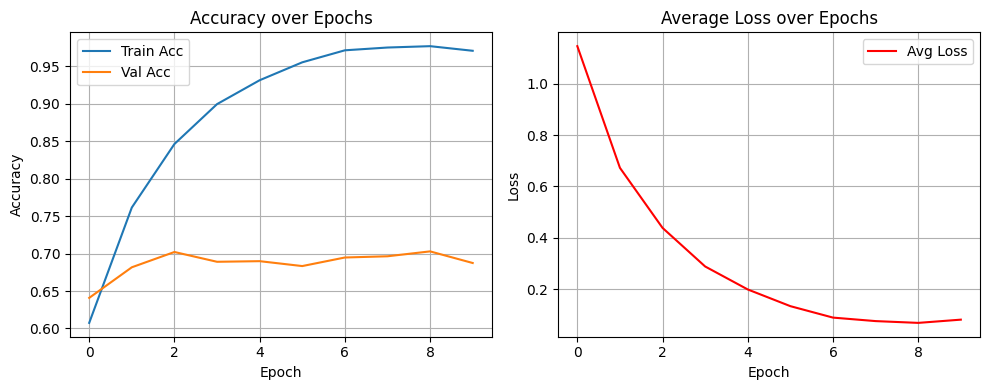

In [6]:
vgg16 = train_model(vgg16, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.6941

              precision    recall  f1-score   support

           1       0.69      0.67      0.68       329
           2       0.61      0.38      0.47        74
           3       0.40      0.16      0.22       160
           4       0.83      0.86      0.84      1185
           5       0.62      0.59      0.60       478
           6       0.65      0.53      0.58       162
           7       0.61      0.73      0.67       680

    accuracy                           0.70      3068
   macro avg       0.63      0.56      0.58      3068
weighted avg       0.69      0.70      0.69      3068



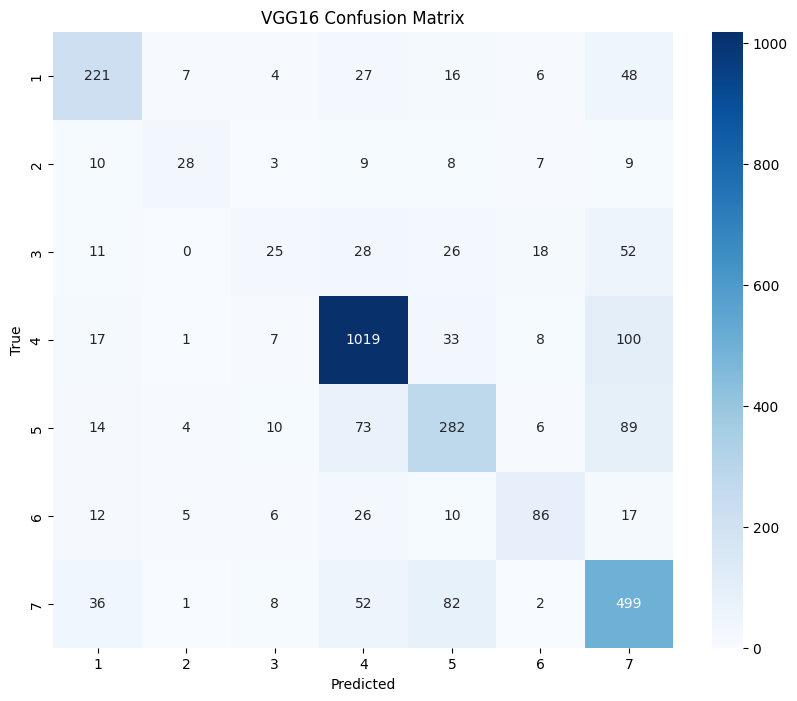

In [7]:
vgg16.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Report
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap='Blues')
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Entire Model Train

Epoch 1/10 | Avg Loss: 0.0706 | Train Acc: 0.9766 | Val Acc: 0.6914
Epoch 2/10 | Avg Loss: 0.0686 | Train Acc: 0.9753 | Val Acc: 0.6931
Epoch 3/10 | Avg Loss: 0.0649 | Train Acc: 0.9785 | Val Acc: 0.6980
Epoch 4/10 | Avg Loss: 0.0755 | Train Acc: 0.9726 | Val Acc: 0.6873
Epoch 5/10 | Avg Loss: 0.0643 | Train Acc: 0.9760 | Val Acc: 0.6882
Epoch 6/10 | Avg Loss: 0.0781 | Train Acc: 0.9743 | Val Acc: 0.6963
Epoch 7/10 | Avg Loss: 0.0607 | Train Acc: 0.9795 | Val Acc: 0.6906
Epoch 8/10 | Avg Loss: 0.0483 | Train Acc: 0.9821 | Val Acc: 0.6890
Epoch 9/10 | Avg Loss: 0.0398 | Train Acc: 0.9870 | Val Acc: 0.6898
Epoch 10/10 | Avg Loss: 0.0546 | Train Acc: 0.9816 | Val Acc: 0.6971


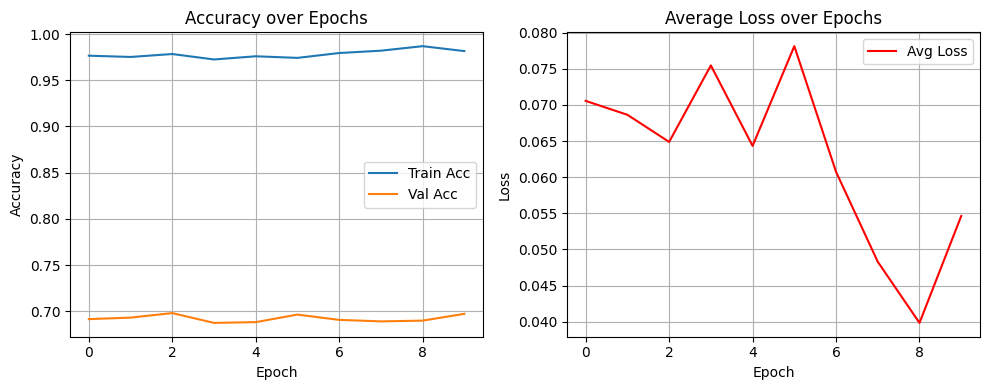

In [8]:
vgg16 = train_model(vgg16, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.6967

              precision    recall  f1-score   support

           1       0.65      0.70      0.67       329
           2       0.81      0.28      0.42        74
           3       0.49      0.19      0.28       160
           4       0.84      0.84      0.84      1185
           5       0.64      0.63      0.63       478
           6       0.58      0.56      0.57       162
           7       0.61      0.73      0.67       680

    accuracy                           0.71      3068
   macro avg       0.66      0.56      0.58      3068
weighted avg       0.70      0.71      0.70      3068



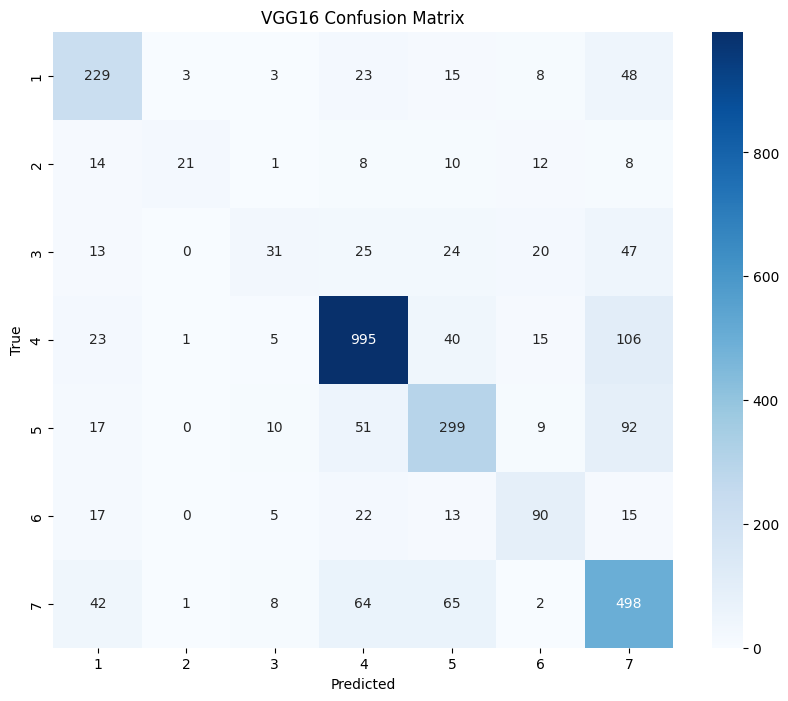

In [9]:
vgg16.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Report
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap='Blues')
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
